## 利用GPT大型模型工具完成数据洞察
### 实验任务： 
对截至2024年8月底在GitHub上具有协作行为日志数据的用户的个人信息（包括姓名、公司、邮箱及其地理位置等）进行数据洞察分析。  
### 分析角度：  
1. **人口统计分析**
- 国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。  
- 城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
- 时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。  
2.**协作行为分析**
- 提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。  
3.**事务类型分析**  
- 查看不同 event_type 的分布，分析每种事件类型的频率  
4.**用户总影响力分析**  
- 计算用户的总影响力（total_influence），并打印影响力最高的10个用户信息  
- 分析影响力与用户提交次数之间的关系

### 1.人口统计分析
#### （1）国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。

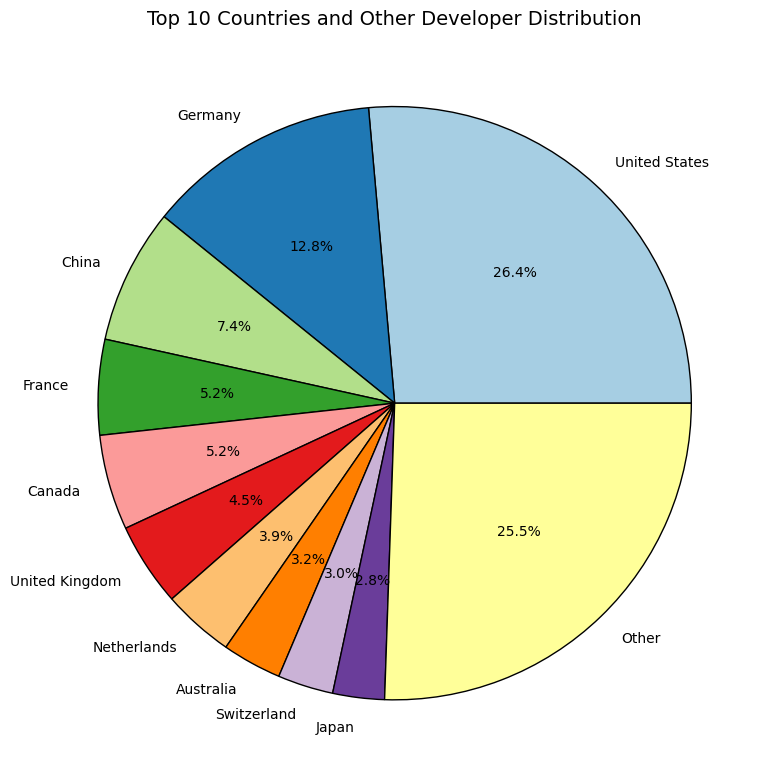

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设加载了数据到 DataFrame df_event
file_path = 'hw12/users_combined_info_500.csv'
df_event = pd.read_csv(file_path)

# （1）统计用户所在国家的分布，并绘制饼状图
# 去重：确保每个 user_id 只计算一次
df_unique_users = df_event.drop_duplicates(subset='user_id')

# 确保'country'列没有空值
df_country = df_unique_users['country'].dropna()

# 统计国家的分布
country_distribution = df_country.value_counts()

# 获取前10个国家
top_10_countries = country_distribution.head(10)

# 将其余的国家合并为"其他"
other_countries = country_distribution.tail(-10).sum()

# 合并为新的系列
country_distribution_pie = pd.concat([top_10_countries, pd.Series({'Other': other_countries})])

# 绘制饼状图
plt.figure(figsize=(8, 8))
country_distribution_pie.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})
plt.title('Top 10 Countries and Other Developer Distribution', fontsize=14)
plt.ylabel('')  # 去除y轴标签
plt.tight_layout()
plt.show()


对uesr_id进行去重，避免提交次数影响用户的统计。  
通过饼状图，我们发现United States用户最多，占比26.4%； Germany次之，占比12.8%，China以用户占比7.4%位居第三。其他国家与地区开发者较分散，占比在6%以下。

#### (2) 城市级别分布：分析主要城市的开发者密度，发现技术热点区域。  
- 在'location'列提取城市信息。  
- 读取数据发现该列仍然存在不少国家信息而非具体的城市，因此添加条件“'location'值与'country'值不同”进行条件过滤，再对'UK'进行特殊过滤，整体达到了过滤效果。
- 同样，注意对user_id去重

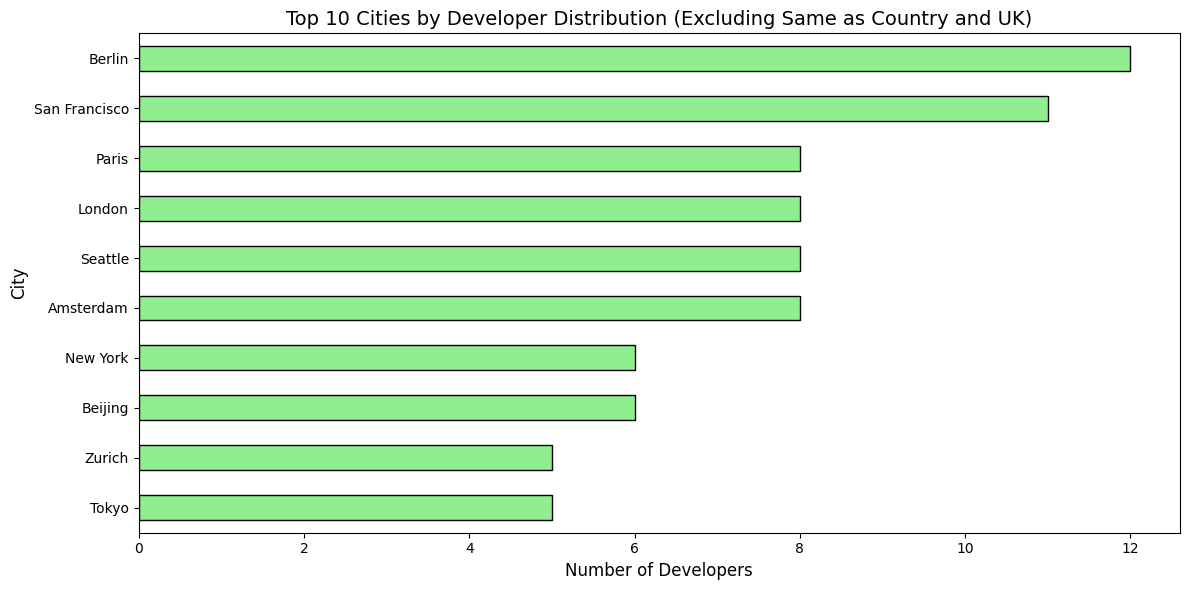

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设加载了数据到 DataFrame df_event
file_path = 'hw12/users_combined_info_500.csv'
df_event = pd.read_csv(file_path)

# 提取城市信息（假设位置格式为“城市, 州/省”）
df_event['city'] = df_event['location'].str.split(',').str[0]  # 获取城市部分

# 去重：确保每个 user_id 只计算一次
df_unique_users = df_event.drop_duplicates(subset='user_id')

# 筛选出城市与国家不同的记录，并且城市不为 'UK'
df_filtered = df_unique_users[(df_unique_users['city'] != df_unique_users['country']) & (df_unique_users['city'] != 'UK')]

# 统计城市的分布
city_distribution = df_filtered['city'].value_counts()

# 绘制城市分布的条形图
plt.figure(figsize=(12, 6))
city_distribution.head(10).plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Top 10 Cities by Developer Distribution (Excluding Same as Country and UK)', fontsize=14)
plt.xlabel('Number of Developers', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.gca().invert_yaxis()  # 反转y轴，最大值在顶部
plt.tight_layout()
plt.show()


通过条形图发现Berlin开发者最多，San Francisco和Paris次之。推测是因为对于用户占比最多的美国来说，用户分散在多个城市降低密度。

#### (3) 时区分布：了解用户的时区分布，分析不同地区用户的协作时间模式。

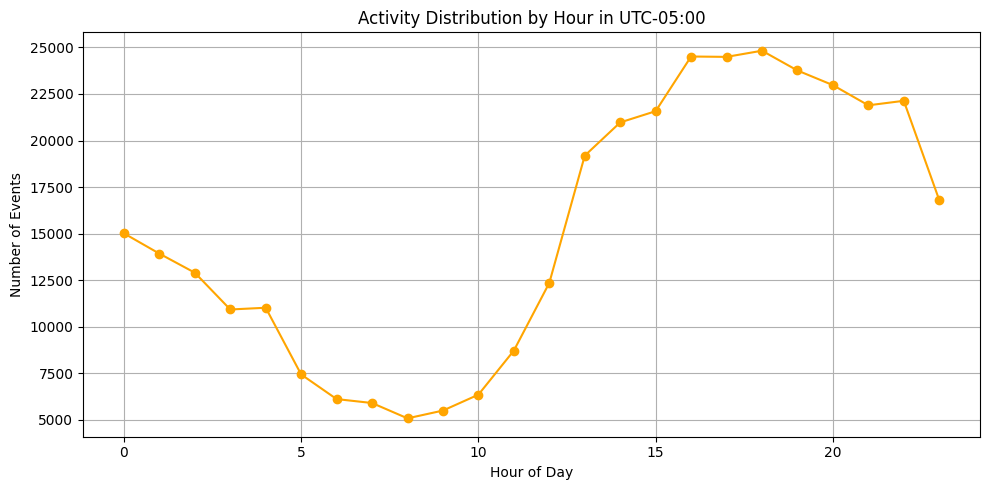

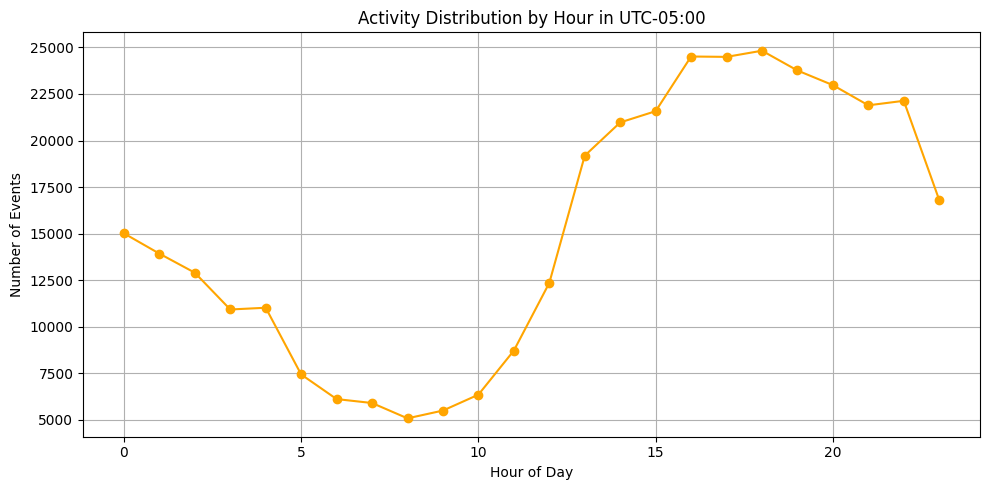

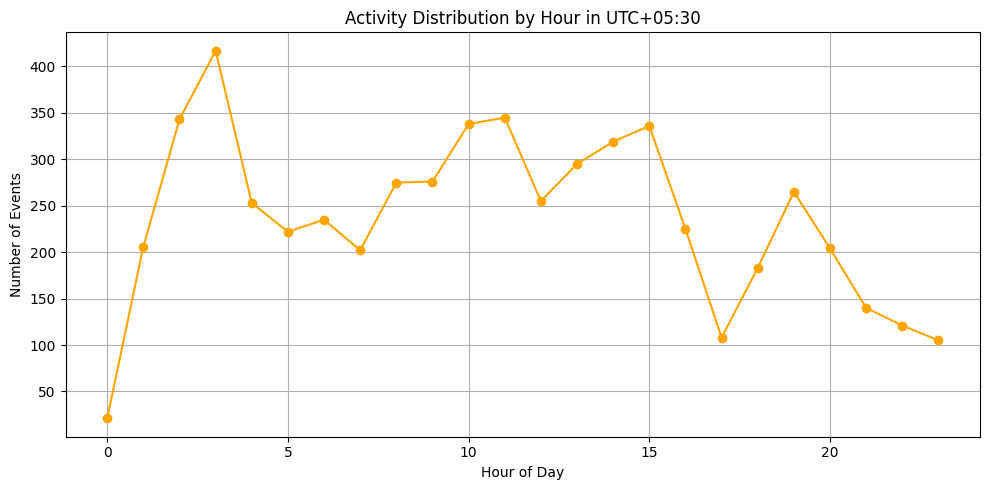

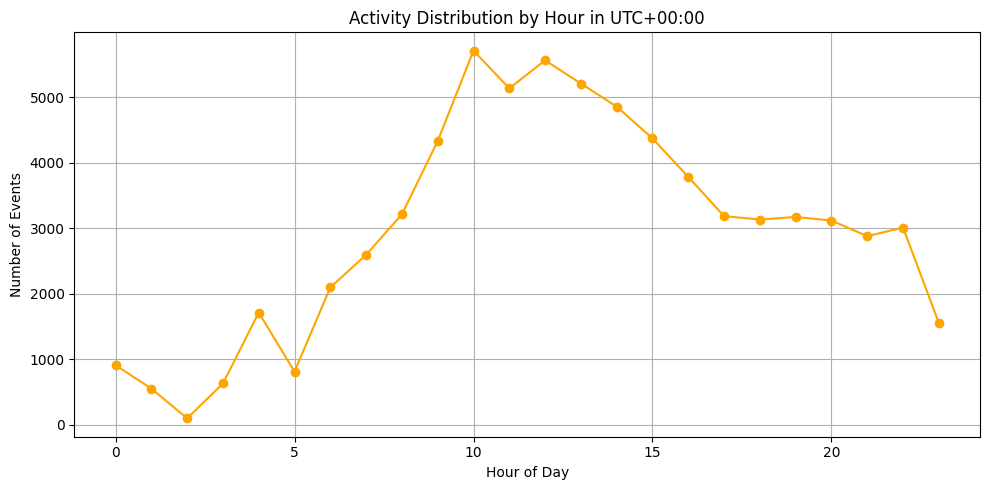

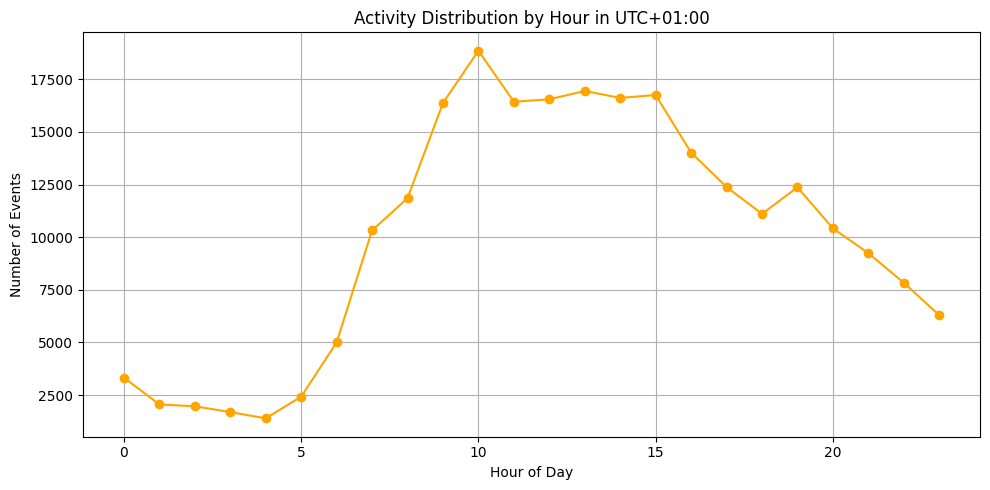

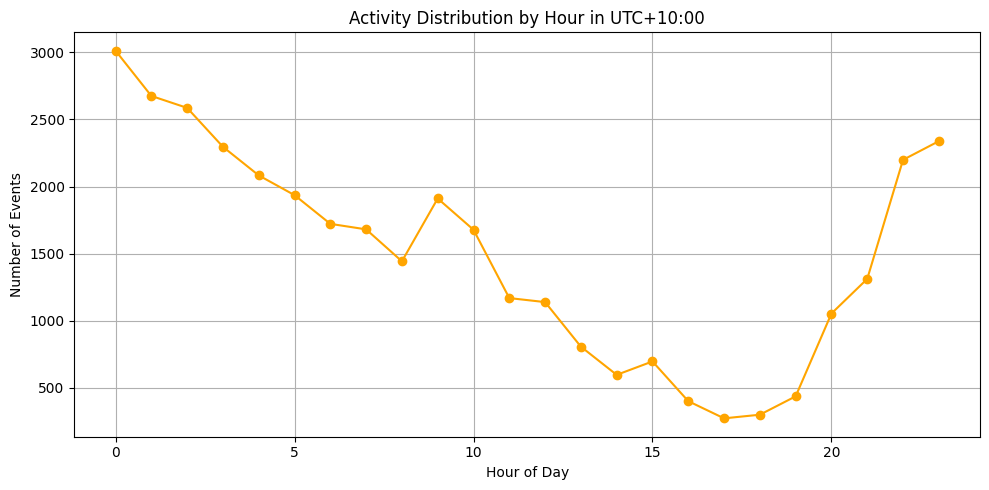

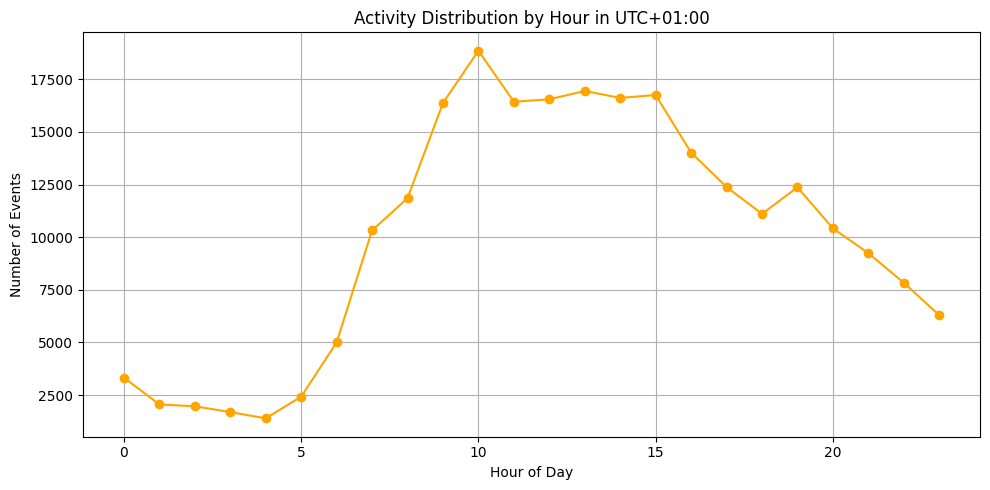

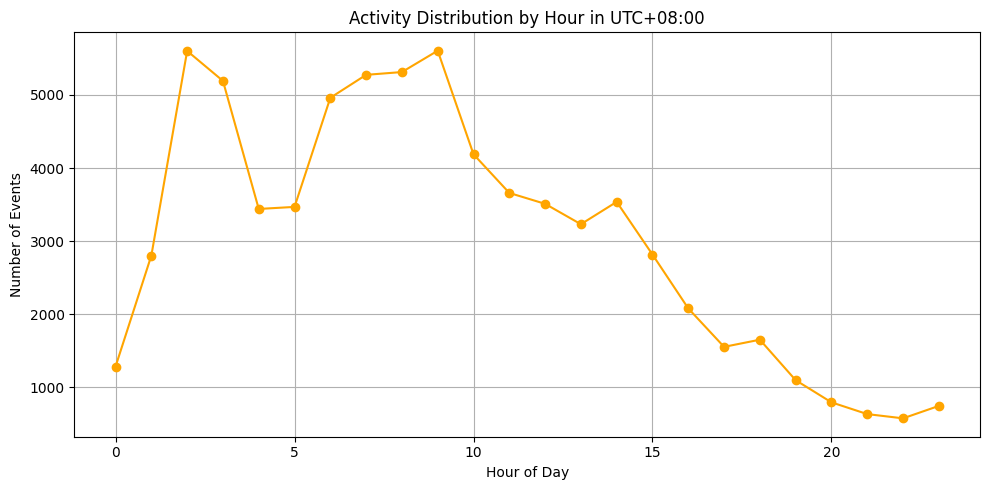

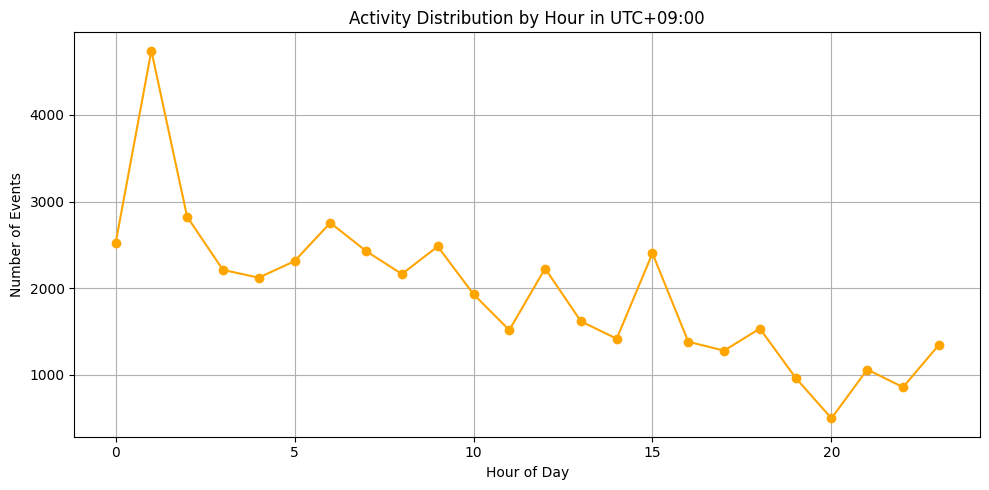

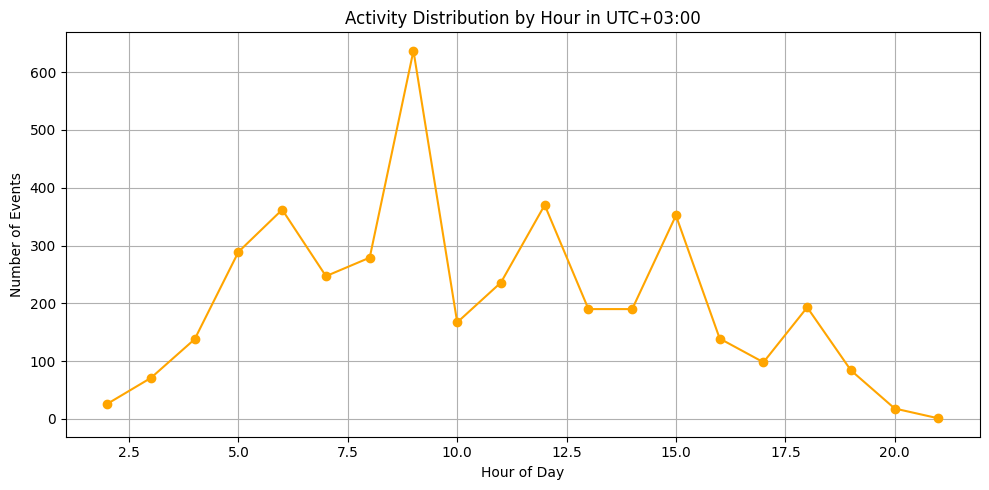

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 数据导入与清理
data_path = 'hw12/users_combined_info_500.csv'
data = pd.read_csv(data_path)

# 先将event_time列转换为字符串类型（方便后续格式检查等操作）
data['event_time'] = data['event_time'].astype(str)

# 过滤有效的event_time
valid_data = data[data['event_time'].str.len() > 10]
valid_data['event_time'] = pd.to_datetime(valid_data['event_time'])

# 补充其时区信息
country_timezone_dict = {
    'United States': 'UTC-05:00', 
    'Canada': 'UTC-05:00',
    'India': 'UTC+05:30',
    'United Kingdom': 'UTC+00:00',
    'Germany': 'UTC+01:00',
    'Australia': 'UTC+10:00',
    'France': 'UTC+01:00',
    'China': 'UTC+08:00',
    'Japan': 'UTC+09:00',
    'Russia': 'UTC+03:00'
}
valid_data['timezone'] = valid_data['country'].map(country_timezone_dict)

# 选取的十个国家对应的时区列表
timezones = list(country_timezone_dict.values())

# 循环处理每个时区的数据，展示其不同小时的事件分布情况
for timezone in timezones:
    timezone_data = valid_data[valid_data['timezone'] == timezone]
    hourly_dist = timezone_data['event_time'].dt.hour.value_counts().sort_index()
    
    plt.figure(figsize=(10, 5))
    plt.plot(hourly_dist.index, hourly_dist.values, marker='o', color='orange')
    plt.title(f'Activity Distribution by Hour in {timezone}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Events')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 2. 协作行为分析
#### (1) 提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。

In [44]:
# 统计每个用户的提交次数（即通过 user_id 聚合）
user_submission_counts = df_event.groupby(['user_id', 'name']).size().reset_index(name='submission_count')

# 打印提交次数最多的十个用户
top_10_users = user_submission_counts.sort_values(by='submission_count', ascending=False).head(10)
print("Top 10 users with the most submissions:")
print(top_10_users)

# 计算所有用户的提交次数的中位数
median_submission_count = user_submission_counts['submission_count'].median()

# 增加一列记录提交次数
df_event = df_event.merge(user_submission_counts[['user_id', 'submission_count']], on='user_id', how='left')

# 增加一列标记高活跃用户和低活跃用户
df_event['activity_level'] = df_event['submission_count'].apply(
    lambda x: 'high active' if x > median_submission_count else 'low active'
)

# 打印结果
print("提交次数中位数：", median_submission_count)
print(df_event[['user_id', 'name', 'submission_count', 'activity_level']].head(10))


Top 10 users with the most submissions:
      user_id                name  submission_count
52     158862             arlac77             37960
345  11146458          MilosKozak             36400
426  28706372           danielroe             30616
179   1580956          chenrui333             20300
448  40306929  ConfluentSemaphore             19215
454  43724913             taiki-e             14505
340   9824526               khipp             12905
467  50149701           bot-targa             12704
63     195327              frenck             11218
119    663432              bdraco             10764
提交次数中位数： 2026.0
   user_id    name  submission_count activity_level
0   663432  bdraco             10764    high active
1   663432  bdraco             10764    high active
2   663432  bdraco             10764    high active
3   663432  bdraco             10764    high active
4   663432  bdraco             10764    high active
5   663432  bdraco             10764    high active
6   6634

统计得用户提交次数的中位数是2026次，提交次数最高的是user_id的158862的arlac77，提交次数为37960次，远高于提交次数的中位数。  
然后对表格增加一列记录用户的提交次数，增加一列标记提交次数高于中位数的为高活跃用户，反之为低活跃用户。  
接着，我们对提交次数进行分层，统计每个层次的用户分布。

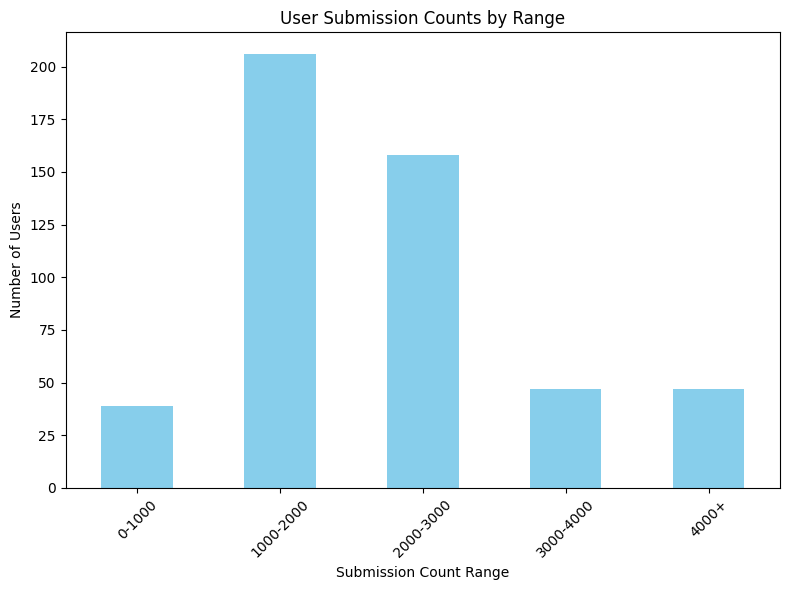

In [45]:
# 定义层次区间: 0-1000次, 1000-2000次, 2000-3000次, 3000-4000次, 4000次以上
bins = [0, 1000, 2000, 3000, 4000, user_submission_counts['submission_count'].max() + 1]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000+']

# 按照层次对用户的提交次数进行分组
user_submission_counts_binned = pd.cut(user_submission_counts['submission_count'], bins=bins, labels=labels)

# 统计每个层次的用户数量
submission_counts_by_bin = user_submission_counts_binned.value_counts().sort_index()

# 绘制条形图
plt.figure(figsize=(8, 6))
submission_counts_by_bin.plot(kind='bar', color='skyblue')
plt.title('User Submission Counts by Range')
plt.xlabel('Submission Count Range')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


通过用户提交次数条形图可知，提交次数为在[1000, 2000]的用户最多约200人，有150人提交次数在[2000, 3000]。提交次数4000以上的用户卧龙凤雏，最高提交次数在30000以上。

### 3. 事件类型（event_type）分析和行为类型（event_action）分析  


不同事件类型的分布：
event_type
PushEvent                        410955
PullRequestEvent                 201128
IssueCommentEvent                174806
PullRequestReviewEvent           151843
CreateEvent                      104371
DeleteEvent                       96999
PullRequestReviewCommentEvent     86198
IssuesEvent                       51205
ReleaseEvent                       9455
WatchEvent                         3809
ForkEvent                          2175
CommitCommentEvent                  704
GollumEvent                         683
MemberEvent                         390
PublicEvent                          55
Name: count, dtype: int64


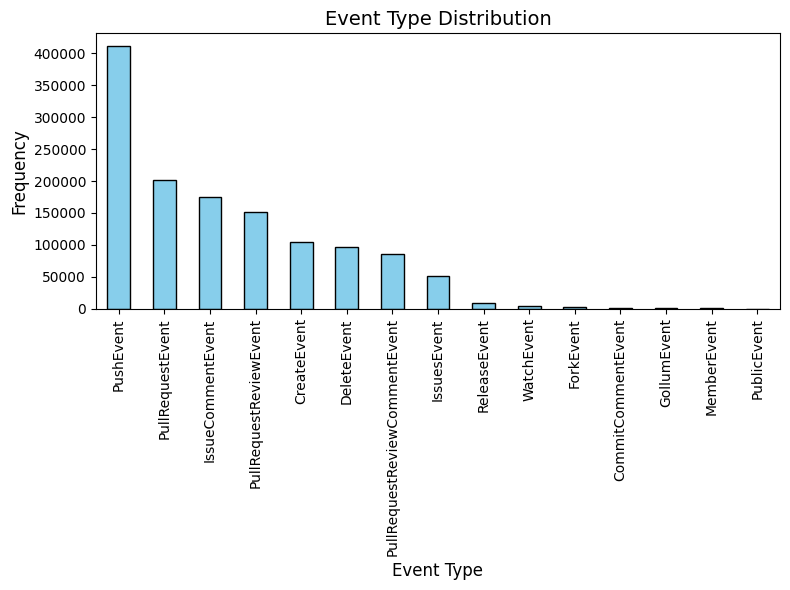


行为类型分布：
event_action
added        617218
created      411961
closed       173489
opened        76406
published      9455
started        3809
reopened       2438
Name: count, dtype: int64


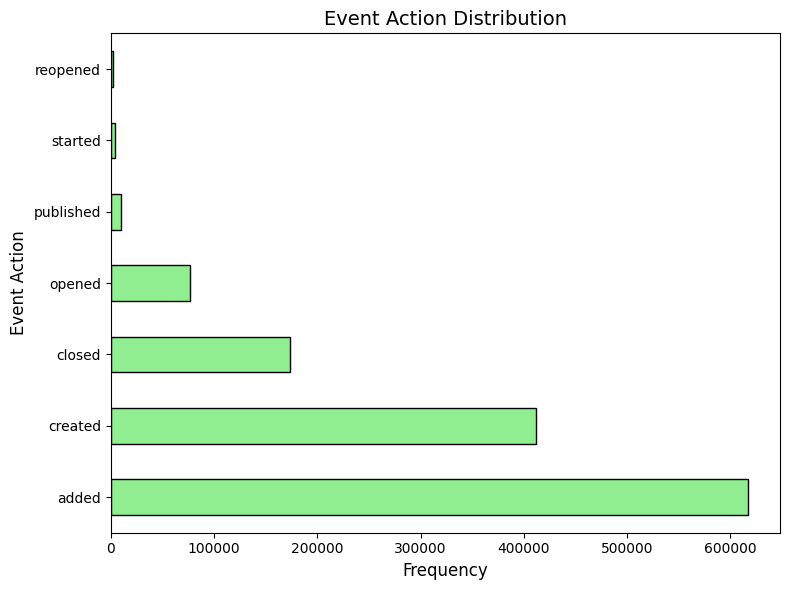

In [46]:
# 查看不同 event_type 的分布，分析每种事件类型的频率
event_type_distribution = df_event['event_type'].value_counts()

# 打印事件类型分布
print("不同事件类型的分布：")
print(event_type_distribution)

# 可视化事件类型分布
plt.figure(figsize=(8, 6))
event_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Event Type Distribution', fontsize=14)
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# (2) 行为类型分析：通过 event_action 字段分析用户执行的行为类型
event_action_distribution = df_event['event_action'].value_counts()

# 打印行为类型分布
print("\n行为类型分布：")
print(event_action_distribution)

# 可视化行为类型分布
plt.figure(figsize=(8, 6))
event_action_distribution.plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Event Action Distribution', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Event Action', fontsize=12)
plt.tight_layout()
plt.show()


#### **事务类型：**  

PushEvent， PullRequestEvent， IssueCommentEvent占比最多。  

**原因分析：**
- PushEvent：推送事件表示用户将更改（如代码、文件等）推送到仓库。这种事件通常与开发工作直接相关，尤其是在团队合作的开发环境中，推送事件是代码管理中不可或缺的一部分。较高的推送事件占比表明，大部分用户或开发者频繁进行代码推送操作。

- PullRequestEvent：拉取请求事件是开发者提出代码更改建议并请求合并到主分支的事件。该事件的高占比表明，协作和代码审查在项目开发中占据重要地位。通常，活跃的开源项目或协作项目会有大量的拉取请求，尤其是当多个开发者参与时。

- IssueCommentEvent：问题评论事件与问题跟踪和讨论密切相关。这种事件的高占比可能意味着项目中存在大量的讨论和问题反馈，开发者、贡献者或用户之间进行积极的沟通和协作。这也可能表明该项目关注社区参与，讨论和解决技术或业务问题的重要性。  


#### **行为类型**  

added， created， closed占比最多。  

**原因分析：**
- added：此行为类型表示将新的内容（如文件、代码段等）添加到仓库中。在开发过程中，"添加"是最常见的操作之一，它通常伴随着新功能的实现、bug 修复或文档更新。较高的“添加”行为占比表明项目中频繁进行功能扩展、资源更新等工作。

- created：表示创建新的事务或资源（如新问题、新分支、新拉取请求等）。这一行为通常与项目启动或开发周期中的新任务、功能模块相关。高占比的“创建”行为可能意味着该项目正在持续扩展，添加新的功能或讨论话题。这可能表明项目处于活跃开发阶段，且在不断生成新的需求和任务。

- closed：表示关闭某个事务，如关闭问题（Issue）、关闭拉取请求（Pull Request）等。关闭事务通常发生在开发过程中完成某个任务或解决某个问题之后。较高的“关闭”行为占比可能表明，项目中有很多问题得到解决，拉取请求也得到审查和合并，开发和维护工作进展顺利。

### 4.用户总影响力分析


影响力最高的10个用户：
        user_id             name  total_influence
0        663432           bdraco      1776.967163
10764   2892853           Koenkk      1674.805908
14641    116184           fabaff      1590.152954
19386   1309177    charliermarsh      1580.198242
24880    195327           frenck      1520.352173
36098  26833433     glenn-jocher      1392.865723
40788   7258858  SuperSandro2000      1220.031738
47037   7083755         joostlek      1219.017944
53246  91018726    mauro-balades      1201.465759
57344  15247171          NickCao      1120.395699


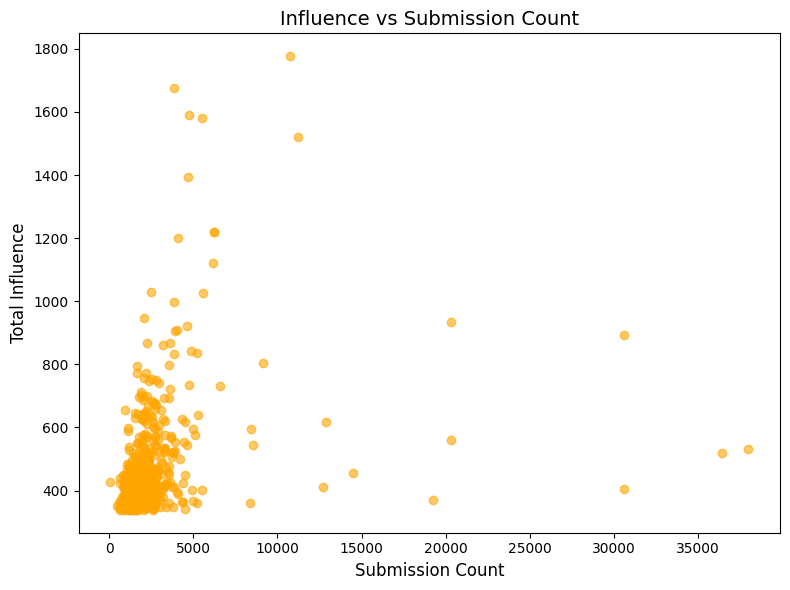

In [47]:
# (1) 计算用户的总影响力（total_influence），并打印影响力最高的10个用户信息
top_10_users_by_influence = df_event[['user_id', 'name', 'total_influence']].drop_duplicates('user_id').sort_values(by='total_influence', ascending=False).head(10)

# 打印影响力最高的10个用户
print("\n影响力最高的10个用户：")
print(top_10_users_by_influence)

# (2) 分析影响力与用户提交次数之间的关系
# 统计每个用户的提交次数
user_submission_counts = df_event.groupby('user_id').size().reset_index(name='submission_count')

# 合并用户提交次数和总影响力
user_data = user_submission_counts.merge(df_event[['user_id', 'total_influence']].drop_duplicates(), on='user_id', how='left')

# 可视化影响力与提交次数的关系
plt.figure(figsize=(8, 6))
plt.scatter(user_data['submission_count'], user_data['total_influence'], alpha=0.6, color='orange')
plt.title('Influence vs Submission Count', fontsize=14)
plt.xlabel('Submission Count', fontsize=12)
plt.ylabel('Total Influence', fontsize=12)
plt.tight_layout()
plt.show()


通过数据发现：  
- 影响力最高的三个用户是bdraco，Koenkk，fabaff，影响力都在1500以上。  
然后分析影响力与用户提交次数之间的关系。  
根据影响力与提交次数的关系的散点图，发现：  
- 大部分用户提交次数集中在0-4000，影响林集中在0-500。  
- 数据集中有个别极端值，如 bdraco 和 Koenkk，他们的影响力显著高于其他用户。这些用户的提交次数也相对较高，说明他们在社区中的活跃程度与影响力呈正相关。  
- 影响力与提交次数之间存在一定的正相关关系。在提交次数0-10000区间，影响力较高的用户通常有较高的提交次数。  

接下来，由于此图中大部分用户分布过于密集，看不出具体的关系，于是单独太久提交次数在0-4000之间的数据。

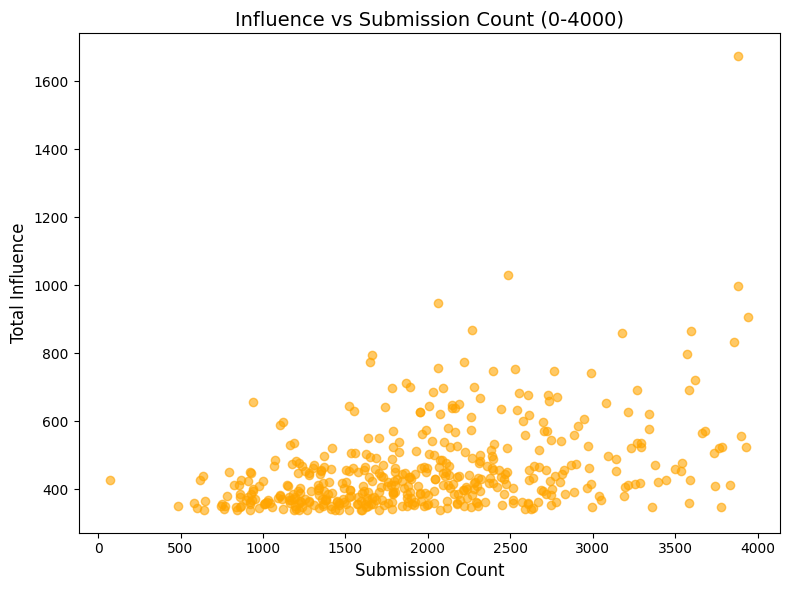

In [48]:
# 筛选出提交次数在 0 到 4000 之间的数据
filtered_data = user_data[(user_data['submission_count'] >= 0) & (user_data['submission_count'] <= 4000)]

# 可视化影响力与提交次数的关系（提交次数在0-4000范围内）
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['submission_count'], filtered_data['total_influence'], alpha=0.6, color='orange')
plt.title('Influence vs Submission Count (0-4000)', fontsize=14)
plt.xlabel('Submission Count', fontsize=12)
plt.ylabel('Total Influence', fontsize=12)
plt.tight_layout()
plt.show()


在提交次数0-4000之间的数据中，我们对于用户提交次数与影响力的关系有更深入的了解。  
- 可以看出，提交次数在1000-2500的用户分布最密集，这部分用户的影响力大部分也集中在400以下，影响力不高，基本属于普通用户。  
- 在每个提交次数对应的影响力的上界，基本是线性增加的。说明最高影响力与提交次数基本是呈线性的。影响力越高的用户，提交次数也更高。基本不会出现提交次数低，但影响力突出的情况。